In [1]:
import pandas as pd

import torch

from transformers import BertTokenizer

from sklearn.model_selection import train_test_split

from transformers import BertModel

import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim

import numpy as np

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())  # Should print True if CUDA is detected

print(torch.cuda.device_count())  # Should return the number of GPUs available

print(torch.cuda.get_device_name(0))  # Should print the name of the GPU (e.g., NVIDIA GeForce RTX 4060)


True
2
Tesla T4


In [2]:
# Load your dataset

data = pd.read_csv("/kaggle/input/cyberguard/Modified_Data.csv")



# Split into train and validation sets

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
from transformers import ElectraTokenizer

# Load the ELECTRA tokenizer
tokenizer = ElectraTokenizer.from_pretrained("google/electra-base-discriminator")




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [3]:
# Tokenize data

def tokenize_data(data):

    return tokenizer(

        data["crimeaditionalinfo"].tolist(),

        padding=True,

        truncation=True,

        max_length=512,

        return_tensors="pt"

    )



# Tokenize both train and validation data

train_encodings = tokenize_data(train_data)

val_encodings = tokenize_data(val_data)


In [4]:
# Convert labels to tensors

train_labels_category = torch.tensor(train_data["category"].values)

train_labels_sub_category = torch.tensor(train_data["sub_category"].values)



val_labels_category = torch.tensor(val_data["category"].values)

val_labels_sub_category = torch.tensor(val_data["sub_category"].values)

In [5]:
# Convert labels to long data type

train_labels_category = train_labels_category.long()

train_labels_sub_category = train_labels_sub_category.long()



val_labels_category = val_labels_category.long()

val_labels_sub_category = val_labels_sub_category.long()

In [6]:
# Create datasets and data loaders

train_dataset = TensorDataset(

    train_encodings['input_ids'], train_encodings['attention_mask'],

    train_labels_category, train_labels_sub_category

)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)



# Similar setup for the validation loader

val_dataset = TensorDataset(

    val_encodings['input_ids'], val_encodings['attention_mask'],

    val_labels_category, val_labels_sub_category

)

val_loader = DataLoader(val_dataset, batch_size=8)
from transformers import XLNetModel

In [7]:
from transformers import ElectraModel

class MultiTaskModel(nn.Module):
    def __init__(self, model_name, num_labels_task1, num_labels_task2):
        super(MultiTaskModel, self).__init__()
        self.electra = ElectraModel.from_pretrained(model_name)
        self.classifier_task1 = nn.Linear(self.electra.config.hidden_size, num_labels_task1)
        self.classifier_task2 = nn.Linear(self.electra.config.hidden_size, num_labels_task2)

    def forward(self, input_ids, attention_mask, labels_task1=None, labels_task2=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        # Use the first token (typically the [CLS] token) for classification
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        logits_task1 = self.classifier_task1(pooled_output)
        logits_task2 = self.classifier_task2(pooled_output)

        loss = None
        if labels_task1 is not None and labels_task2 is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss_task1 = loss_fn(logits_task1, labels_task1)
            loss_task2 = loss_fn(logits_task2, labels_task2)
            loss = loss_task1 + loss_task2

        return {"loss": loss, "logits_task1": logits_task1, "logits_task2": logits_task2}


In [8]:
num_labels_task1 = 15

num_labels_task2 = 35

from transformers import XLNetTokenizer, XLNetForSequenceClassification


print(f"Unique classes in 'category': {num_labels_task1}")

print(f"Unique classes in 'sub_category': {num_labels_task2}")



# Initialize the model with dynamic class counts

model = MultiTaskModel("google/electra-base-discriminator", num_labels_task1=num_labels_task1, num_labels_task2=num_labels_task2)

model.to(device)

Unique classes in 'category': 15
Unique classes in 'sub_category': 35


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

MultiTaskModel(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), e

In [9]:
# Create data loaders

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'],

                              train_labels_category, train_labels_sub_category)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)



# Optimizer

optimizer = optim.AdamW(model.parameters(), lr=2.5e-5)

In [10]:
# Initialize lists to store metrics

train_accuracies_task1 = []

train_accuracies_task2 = []

val_accuracies_task1 = []

val_accuracies_task2 = []

In [11]:
# Example Training Loop with Accuracy Tracking

for epoch in range(5):

    model.train()

    total_train_loss = 0

    train_preds_task1, train_preds_task2 = [], []

    train_labels_task1, train_labels_task2 = [], []



    for batch in train_loader:

        # Move batch data to the device

        input_ids = batch[0].to(device)

        attention_mask = batch[1].to(device)

        labels_task1 = batch[2].to(device)

        labels_task2 = batch[3].to(device)



        # Forward pass

        outputs = model(input_ids=input_ids, attention_mask=attention_mask,

                        labels_task1=labels_task1, labels_task2=labels_task2)



        loss = outputs["loss"]

        total_train_loss += loss.item()



        # Backpropagation

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()



        # Move predictions and labels back to CPU for accuracy calculation

        train_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())

        train_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())

        train_labels_task1.extend(labels_task1.cpu().numpy())

        train_labels_task2.extend(labels_task2.cpu().numpy())



    # Calculate training accuracy

    train_accuracy_task1 = accuracy_score(train_labels_task1, train_preds_task1)

    train_accuracy_task2 = accuracy_score(train_labels_task2, train_preds_task2)

    train_accuracies_task1.append(train_accuracy_task1)

    train_accuracies_task2.append(train_accuracy_task2)



    # Validation phase

    model.eval()

    val_preds_task1, val_preds_task2 = [], []

    val_labels_task1, val_labels_task2 = [], []

    with torch.no_grad():

        for batch in val_loader:

            # Move batch data to the device

            input_ids = batch[0].to(device)

            attention_mask = batch[1].to(device)

            labels_task1 = batch[2].to(device)

            labels_task2 = batch[3].to(device)



            # Forward pass

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)



            # Move predictions and labels back to CPU for accuracy calculation

            val_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())

            val_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())

            val_labels_task1.extend(labels_task1.cpu().numpy())

            val_labels_task2.extend(labels_task2.cpu().numpy())



    # Calculate validation accuracy

    val_accuracy_task1 = accuracy_score(val_labels_task1, val_preds_task1)

    val_accuracy_task2 = accuracy_score(val_labels_task2, val_preds_task2)

    val_accuracies_task1.append(val_accuracy_task1)

    val_accuracies_task2.append(val_accuracy_task2)



    print(f"Epoch {epoch+1} - Training Loss: {total_train_loss / len(train_loader)}")

    print(f"Task 1 - Training Accuracy: {train_accuracy_task1}, Validation Accuracy: {val_accuracy_task1}")

    print(f"Task 2 - Training Accuracy: {train_accuracy_task2}, Validation Accuracy: {val_accuracy_task2}")


Epoch 1 - Training Loss: 2.2327655109828854
Task 1 - Training Accuracy: 0.7756499519085832, Validation Accuracy: 0.7846683893195521
Task 2 - Training Accuracy: 0.5061657502978797, Validation Accuracy: 0.5568188343382142
Epoch 2 - Training Loss: 1.9190895595477846
Task 1 - Training Accuracy: 0.797039865631146, Validation Accuracy: 0.7908125179443009
Task 2 - Training Accuracy: 0.5644066093397838, Validation Accuracy: 0.5695090439276486
Epoch 3 - Training Loss: 1.7899072380735614
Task 1 - Training Accuracy: 0.8135057925034812, Validation Accuracy: 0.7959804766006316
Task 2 - Training Accuracy: 0.5911511793163841, Validation Accuracy: 0.5778351995406259
Epoch 4 - Training Loss: 1.6869890229647306
Task 1 - Training Accuracy: 0.8276173933016552, Validation Accuracy: 0.801952339936836
Task 2 - Training Accuracy: 0.6095551185058643, Validation Accuracy: 0.5834051105368935
Epoch 5 - Training Loss: 1.5616253096290313
Task 1 - Training Accuracy: 0.8484617924460587, Validation Accuracy: 0.7815101

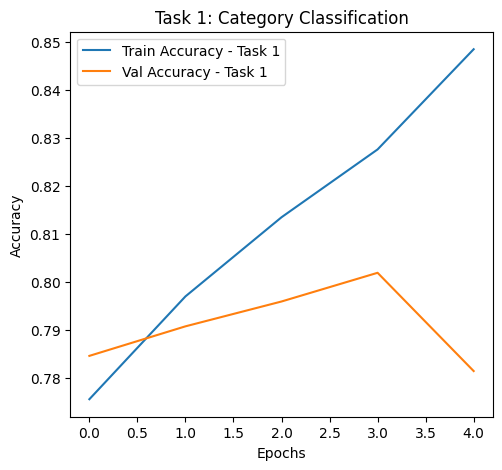

In [12]:
# Plot Training and Validation Accuracy for Task 1

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

plt.plot(train_accuracies_task1, label='Train Accuracy - Task 1')

plt.plot(val_accuracies_task1, label='Val Accuracy - Task 1')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.title('Task 1: Category Classification')

plt.legend()

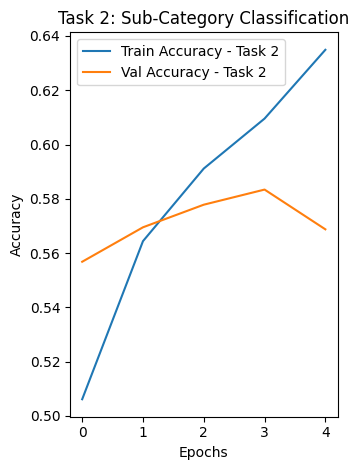

In [13]:
# Plot Training and Validation Accuracy for Task 2

plt.subplot(1, 2, 2)

plt.plot(train_accuracies_task2, label='Train Accuracy - Task 2')

plt.plot(val_accuracies_task2, label='Val Accuracy - Task 2')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.title('Task 2: Sub-Category Classification')

plt.legend()



plt.tight_layout()

plt.show()
